In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import numpy as np

from model_utils import lr_scheduler, restore_weights, save_model
from data_generator import SemanticSegmentationDataset
from train import build_model, train_loop
from evaluate import evaluate, show_sample_segmentation

from pathlib import Path

### Define parameters

In [2]:
batch_size = 1
shuffle = True
epoch_start = 0
epochs = 100
T_save = 1
T_print = 100
num_classes = 4
cuda = True

pretrained_weight_fname = 'resnet_v2-300epoch.pth'
weights_dir = 'weights/'
data_dir = 'drinks/'
train_gt_fname = 'segmentation_train.npy'
test_gt_fname = 'segmentation_test.npy'

# make path if not exist
Path(weights_dir).mkdir(parents=True, exist_ok=True)

### Initialize dataloaders

In [3]:
trainset = SemanticSegmentationDataset(data_dir, train_gt_fname, cuda=cuda)
trainloader = DataLoader(trainset,
                         batch_size=batch_size,
                         shuffle=shuffle)
testset = SemanticSegmentationDataset(data_dir, test_gt_fname, cuda=cuda)
testloader = DataLoader(testset,
                        batch_size=batch_size,
                        shuffle=shuffle)

## Training

### Initialize model

In [4]:
# initialize model
channels, height, width = 3, 480, 640
input_shape = (batch_size, channels, height, width)

model, backbone = build_model(input_shape=input_shape,
                              n_classes=num_classes,
                              weights_dir=weights_dir,
                              pretrained_weight_fname=pretrained_weight_fname,
                              cuda=cuda)

Restoring weights from weights/resnet_v2-300epoch.pth


### Initialize training parameters

In [5]:
# initialize training parameters
# based on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
criterion = nn.CrossEntropyLoss()   # categorical crossentropy
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_scheduler)

Learning rate: 0.001


### Train loop

In [0]:
train_loop(model, criterion, optimizer, scheduler, trainloader,
           epochs=epochs, epoch_start=epoch_start,
           T_print=T_print, T_save=T_save)

In [5]:
m_iou, m_pla = evaluate(model, testloader, T_print=1)

/home/eee198/anaconda3/envs/ocr2/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0) IoU = 0.677133	pla = 83.007812
1) IoU = 0.594096	pla = 67.441406
2) IoU = 0.630677	pla = 71.406250
3) IoU = 0.659430	pla = 71.787109
4) IoU = 0.659044	pla = 74.031250
5) IoU = 0.684909	pla = 73.815104
6) IoU = 0.712489	pla = 74.218750
7) IoU = 0.728204	pla = 71.953125
8) IoU = 0.734913	pla = 72.239583
9) IoU = 0.730630	pla = 72.671875
10) IoU = 0.738631	pla = 72.144886
11) IoU = 0.721168	pla = 70.439453
12) IoU = 0.727512	pla = 70.913462
13) IoU = 0.723835	pla = 71.916853
14) IoU = 0.735035	pla = 72.187500
15) IoU = 0.735725	pla = 72.119141
16) IoU = 0.741163	pla = 72.295496
17) IoU = 0.741195	pla = 71.983507
18) IoU = 0.742557	pla = 71.854441
19) IoU = 0.749457	pla = 71.564453
20) IoU = 0.750853	pla = 71.722470
21) IoU = 0.752060	pla = 71.981534
22) IoU = 0.752710	pla = 72.333560
23) IoU = 0.751319	pla = 72.304688
24) IoU = 0.752598	pla = 72.351562
25) IoU = 0.752717	pla = 72.241587
26) IoU = 0.748821	pla = 71.960359
27) IoU = 0.749000	pla = 72.007533
28) IoU = 0.751601	pla = 71.93

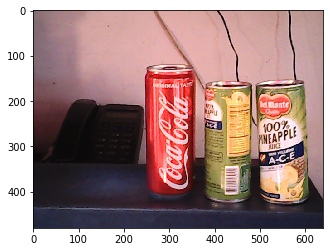

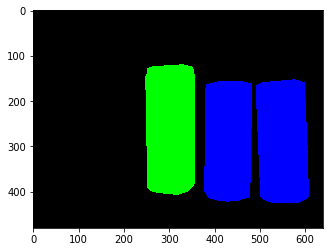

/home/eee198/anaconda3/envs/ocr2/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


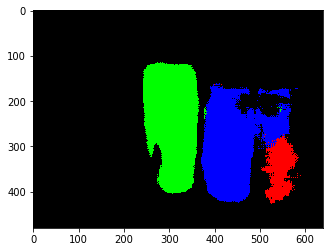

IoU: 0.7417357882083381
pla: 66.6796875


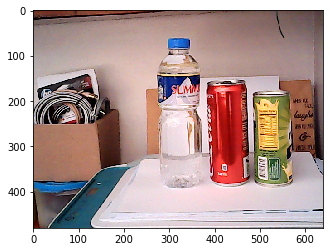

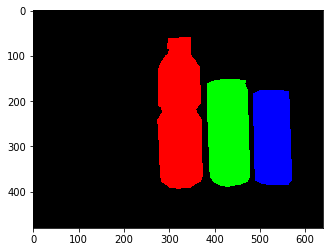

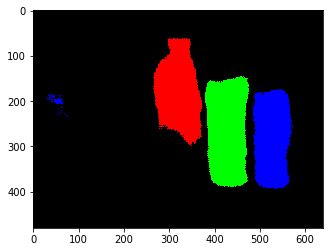

IoU: 0.8142324715254029
pla: 72.734375


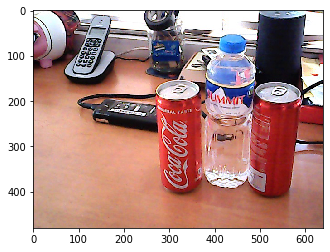

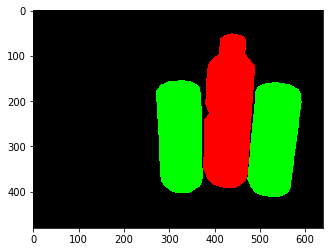

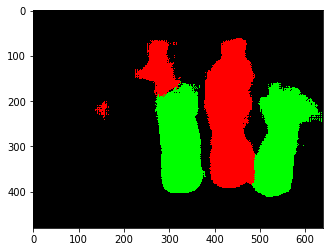

IoU: 0.7961150669696457
pla: 62.22656250000001


In [5]:
for _ in range(3):
    show_sample_segmentation(model, testloader)